In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-classification/train.csv.zip
/kaggle/input/leaf-classification/sample_submission.csv.zip
/kaggle/input/leaf-classification/images.zip
/kaggle/input/leaf-classification/test.csv.zip


### Importing Libraries

In [2]:
# Importing some useful/necessary packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cv2
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.metrics import accuracy_score


### Reading the data

In [3]:
train_df= pd.read_csv('/kaggle/input/leaf-classification/train.csv.zip')
test_df=pd.read_csv('/kaggle/input/leaf-classification/test.csv.zip')
train_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


### Data Analysis

In [4]:
test_ids = test_df.id
test_data = test_df.drop(['id'], axis =1)
test_data.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


#### Checking for null values

In [5]:
train_df.isnull().sum()

id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64

#### Data shape

In [6]:
train_df.shape

(990, 194)

In [7]:
test_data.shape

(594, 192)

In [8]:
train_df.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


In [9]:
train_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Cornus_Controversa     10
Quercus_Pubescens      10
Celtis_Koraiensis      10
Acer_Platanoids        10
Alnus_Maximowiczii     10
                       ..
Alnus_Cordata          10
Quercus_Suber          10
Quercus_Trojana        10
Quercus_Rhysophylla    10
Quercus_Kewensis       10
Name: species, Length: 99, dtype: int64


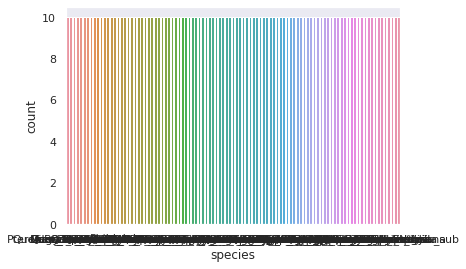

In [10]:

ax=sns.countplot(train_df["species"])
target_temp0 = train_df.species.value_counts()
print(target_temp0)

In [11]:
train_df['species'].nunique()

99

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.000000    203
0.001953    105
0.003906     61
0.005859     51
0.007812     47
0.009766     41
0.011719     39
0.013672     33
0.015625     33
0.017578     33
0.021484     26
0.025391     26
0.019531     26
0.023438     23
0.027344     18
0.029297     17
0.060547     15
0.033203     15
0.050781     15
0.037109     14
0.052734     13
0.035156     12
0.039062     11
0.031250     11
0.056641     10
0.046875     10
0.041016     10
0.042969      9
0.064453      7
0.048828      6
0.058594      6
0.068359      6
0.062500      6
0.044922      5
0.054688      5
0.072266      4
0.082031      3
0.080078      3
0.078125      2
0.066406      2
0.076172      2
0.070312      2
0.087891      1
0.085938      1
0.074219      1
0.083984      1
Name: margin1, dtype: int64


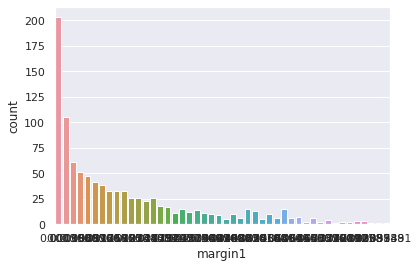

In [12]:
ax=sns.countplot(train_df["margin1"])
target_temp = train_df.margin1.value_counts()
print(target_temp)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.000000    255
0.000977     48
0.001953     44
0.003906     38
0.002930     36
           ... 
0.380860      1
0.064453      1
0.066406      1
0.122070      1
0.131840      1
Name: texture1, Length: 133, dtype: int64


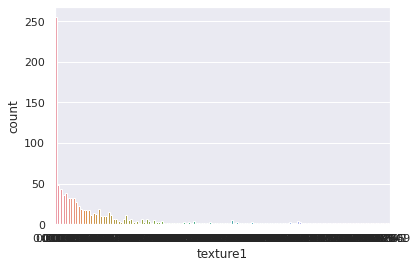

In [13]:
ax=sns.countplot(train_df["texture1"])
target_temp = train_df.texture1.value_counts()
print(target_temp)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.000000    397
0.000977     32
0.001953     22
0.003906     21
0.002930     20
           ... 
0.131840      1
0.282230      1
0.166020      1
0.189450      1
0.256840      1
Name: texture55, Length: 182, dtype: int64


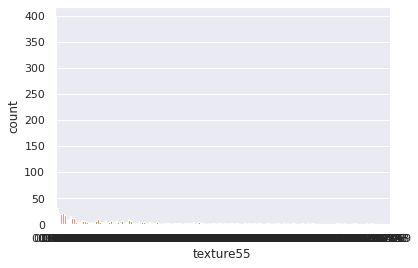

In [14]:
ax=sns.countplot(train_df["texture55"])
target_temp = train_df.texture55.value_counts()
print(target_temp)

### Machine learning

<AxesSubplot:>

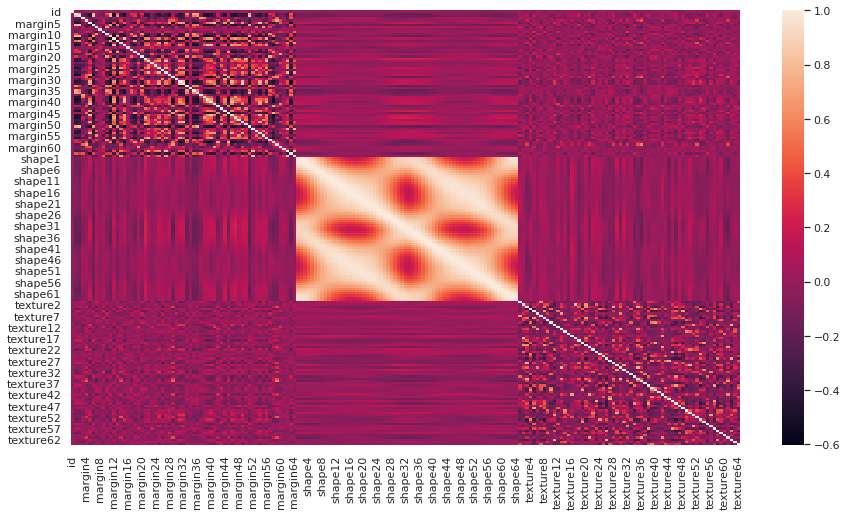

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(data=train_df.corr())

In [16]:
X = train_df.drop(['id','species'],axis=1)
Y = train_df['species']

In [17]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_fit = encoder.fit(train_df['species'])
y_label = y_fit.transform(train_df['species']) 
classes = list(y_fit.classes_) 
classes

['Acer_Capillipes',
 'Acer_Circinatum',
 'Acer_Mono',
 'Acer_Opalus',
 'Acer_Palmatum',
 'Acer_Pictum',
 'Acer_Platanoids',
 'Acer_Rubrum',
 'Acer_Rufinerve',
 'Acer_Saccharinum',
 'Alnus_Cordata',
 'Alnus_Maximowiczii',
 'Alnus_Rubra',
 'Alnus_Sieboldiana',
 'Alnus_Viridis',
 'Arundinaria_Simonii',
 'Betula_Austrosinensis',
 'Betula_Pendula',
 'Callicarpa_Bodinieri',
 'Castanea_Sativa',
 'Celtis_Koraiensis',
 'Cercis_Siliquastrum',
 'Cornus_Chinensis',
 'Cornus_Controversa',
 'Cornus_Macrophylla',
 'Cotinus_Coggygria',
 'Crataegus_Monogyna',
 'Cytisus_Battandieri',
 'Eucalyptus_Glaucescens',
 'Eucalyptus_Neglecta',
 'Eucalyptus_Urnigera',
 'Fagus_Sylvatica',
 'Ginkgo_Biloba',
 'Ilex_Aquifolium',
 'Ilex_Cornuta',
 'Liquidambar_Styraciflua',
 'Liriodendron_Tulipifera',
 'Lithocarpus_Cleistocarpus',
 'Lithocarpus_Edulis',
 'Magnolia_Heptapeta',
 'Magnolia_Salicifolia',
 'Morus_Nigra',
 'Olea_Europaea',
 'Phildelphus',
 'Populus_Adenopoda',
 'Populus_Grandidentata',
 'Populus_Nigra',
 'Pr

In [18]:
from sklearn.model_selection import  train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y_label, test_size = 0.2, random_state =1)

In [19]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 40)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_estimators=40)

In [20]:
from sklearn.metrics import classification_report
predictions = classifier.predict(x_test)
print (classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         3
          10       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
final_predictions = classifier.predict_proba(test_data)

In [22]:
submission = pd.DataFrame(final_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()

,index,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,0,4,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,...,0.0,0.00,0.000,0.0,0.0,0.000,0.000,0.000,0.025,0.000
1,1,7,0.000,0.000,0.025,0.000,0.000,0.000,0.050,0.025,...,0.0,0.00,0.000,0.0,0.0,0.025,0.000,0.025,0.000,0.000
2,2,9,0.000,0.475,0.000,0.000,0.075,0.025,0.000,0.000,...,0.0,0.00,0.025,0.0,0.0,0.000,0.025,0.000,0.000,0.000
3,3,12,0.000,0.050,0.000,0.025,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.0,0.0,0.025,0.050,0.000,0.000,0.000
4,4,13,0.050,0.050,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,589,1576,0.000,0.675,0.000,0.000,0.050,0.000,0.000,0.000,...,0.0,0.00,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000
590,590,1577,0.025,0.000,0.025,0.000,0.000,0.025,0.000,0.100,...,0.0,0.00,0.000,0.0,0.0,0.025,0.000,0.000,0.000,0.025
591,591,1579,0.000,0.000,0.000,0.000,0.075,0.025,0.000,0.000,...,0.0,0.00,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.025
592,592,1580,0.025,0.000,0.025,0.050,0.000,0.000,0.025,0.000,...,0.0,0.05,0.000,0.0,0.0,0.050,0.000,0.025,0.000,0.000


In [23]:
submission.to_csv('result.csv', index = False)

### Logistic regression

In [24]:
model = LogisticRegression()
model.fit(x_train, y_train)
prediction = model.predict(x_test)
print('Accuracy:',metrics.accuracy_score(prediction,y_test))

Accuracy: 0.17676767676767677


In [25]:
logreg001 = LogisticRegression(C=0.4).fit(x_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg001.score(x_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg001.score(x_test, y_test)))

Training set accuracy: 0.191
Test set accuracy: 0.040


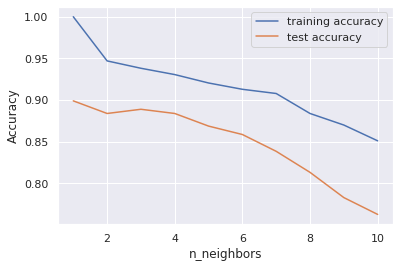

In [26]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(x_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(x_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

In [27]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(x_test, y_test)))

Accuracy of K-NN classifier on training set: 0.91
Accuracy of K-NN classifier on test set: 0.84


### Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.586


In [29]:
tree = DecisionTreeClassifier(max_depth=4, random_state=1)
tree.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))

Accuracy on training set: 0.115
Accuracy on test set: 0.045


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.975


In [31]:
rf1 = RandomForestClassifier(max_depth=9, n_estimators=100, random_state=1)
rf1.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf1.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf1.score(x_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.833


### Gradient Boost

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.636


In [33]:
gb1 = GradientBoostingClassifier(random_state=0, max_depth=1)
gb1.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb1.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb1.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.641


### Support Vector Machine

In [34]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(x_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(x_test, y_test)))

Accuracy on training set: 0.98
Accuracy on test set: 0.89


### Gaussian Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(x_train, y_train)

y_pred_nb = model.predict(x_test)
print(y_pred_nb)

[69 47  2  3  6 81 64 75 71 14 98 65 85 24 14 49 48 46 26 32 20 69 92 50
 19 63 78 62 50 56 63 55 73 43 55 26 81 70 16 26  2 38 65 85 31 32 19  3
 28 15 83 17 95 69 78  8 27 85 83 70 70 83 24 78 85  4 12 48 85 89 46 82
 65 23 46 38  3 20 85 87 19 36 12 98 85 68 51 65  1 83 12 55 14 94 70 36
 77 50 26 11 19 47 19 70 80 20 22 12 40 20 69 83 95 95 69 36 68 47 94 51
 16 77 26 47 90 79 78 92 36 26 79 87 92 40 26 41 84  9 60 67 83 86 85 74
 95 26 14 36 77 19 53 85 58 14 10 52  8 53 42 26 22 77 51 14 45 98 68 77
 18 96 86 89 70 54 25 85 50 41 94 70 61 80 80 87 45 14 19 91 12 68 87 63
 47 22 71 70 45 47]


In [36]:
score_nb = round(accuracy_score(y_pred_nb,y_test)*100,2)

print("The accuracy score using Naive Bayes is: "+str(score_nb)+" %")

The accuracy score using Naive Bayes is: 47.47 %


### Neural Networks

In [37]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(x_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(x_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(x_test, y_test)))

Accuracy on training set: 0.95
Accuracy on test set: 0.85


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.fit_transform(x_test)

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.960


In [39]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985


In [40]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985


In [41]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985


In [42]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985


In [43]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985
